c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


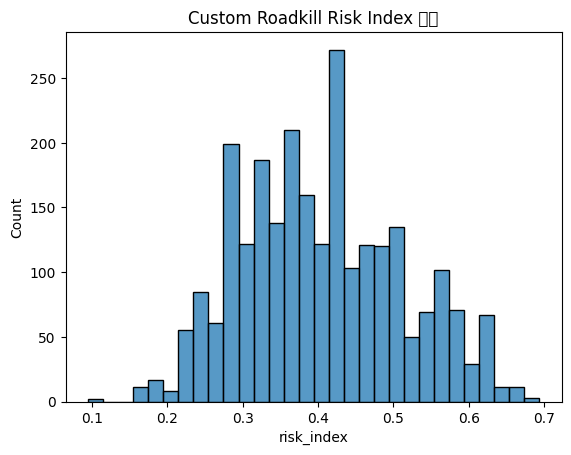

In [4]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ 1. 데이터 불러오기
df = pd.read_csv(r'data/post_grouped_1km_0714.csv')

# ✅ 2. 오버샘플링 유사 처리 (count 클리핑 반복)
df_no_roadkill = df[df['count'] == 0]
df_roadkill = df[df['count'] > 0].loc[df.index.repeat(df['count'].clip(upper=10))]
df_balanced = pd.concat([df_no_roadkill, df_roadkill]).reset_index(drop=True)

# ✅ 3. 스케일링할 컬럼 지정
features_to_scale = ['traffic', 'fence', 'eco', 'agri', 'water', '1km_inner',
    'avg_low_temp_springautumn', 'avg_low_temp_summer', 'avg_low_temp_winter',
    'avg_temp_springautumn', 'avg_temp_summer', 'avg_temp_winter',
    'avg_wind_springautumn', 'avg_wind_summer', 'avg_wind_winter',
    'max_snow_springautumn', 'max_snow_summer', 'max_snow_winter',
    'month_total_rain_springautumn', 'month_total_rain_summer', 'month_total_rain_winter'
]

scaler = MinMaxScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df_balanced[features_to_scale]), columns=features_to_scale)

# ✅ 4. 위험지수 구성요소 정의
A = scaled_df[['traffic', '1km_inner']].mean(axis=1)
B = 1 - scaled_df[['fence', 'eco']].mean(axis=1)  # 시설 없을수록 위험 ↑
C = scaled_df[['water', 'agri', 'avg_temp_springautumn', 'avg_temp_winter', 'month_total_rain_winter']].mean(axis=1)
D = scaled_df[['max_snow_winter', 'avg_low_temp_winter']].mean(axis=1)

# ✅ 5. 가중치 반영 지수 계산 (ex-ARI 방식)
df_balanced['risk_index'] = (
    A * 1 +
    B * 1.46 +
    C * 1.78 +
    D * 1.28
) / (1 + 1.46 + 1.78 + 1.28)

# ✅ 6. 분포 확인 (선택)
sns.histplot(df_balanced['risk_index'], bins=30)
plt.title("Custom Roadkill Risk Index 분포")
plt.show()

# ✅ 7. 모델 입력용 X, y 정의
X = df_balanced[[
    'post_group', 'year', 'traffic', 'fence', 'eco', 'agri', 'water', '1km_inner',
    'avg_low_temp_springautumn', 'avg_low_temp_summer', 'avg_low_temp_winter',
    'avg_temp_springautumn', 'avg_temp_summer', 'avg_temp_winter',
    'avg_wind_springautumn', 'avg_wind_summer', 'avg_wind_winter',
    'max_snow_springautumn', 'max_snow_summer', 'max_snow_winter',
    'month_total_rain_springautumn', 'month_total_rain_summer', 'month_total_rain_winter',
    'risk_index'  # 추가된 위험도 지표
]]
y = (df_balanced['count'] > 0).astype(int)

✅ Feature shape: (2190, 44)
✅ SMOTE 후 분포:
 target
1    1680
0    1680
Name: count, dtype: int64

✅ Classification Report

              precision    recall  f1-score   support

           0       0.96      0.86      0.91       420
           1       0.03      0.11      0.05        18

    accuracy                           0.83       438
   macro avg       0.50      0.49      0.48       438
weighted avg       0.92      0.83      0.87       438


✅ Confusion Matrix

[[361  59]
 [ 16   2]]


c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:46:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\user\AppData\Local\Temp\ipykernel_216\1791953490.py:105: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_216\1791953490.py:105: UserWarning: Glyph 49373 (\N{HANGUL SYLLABLE SAENG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_216\1791953490.py:105: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_216\1791953490.py:105: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\user\AppData\Lo

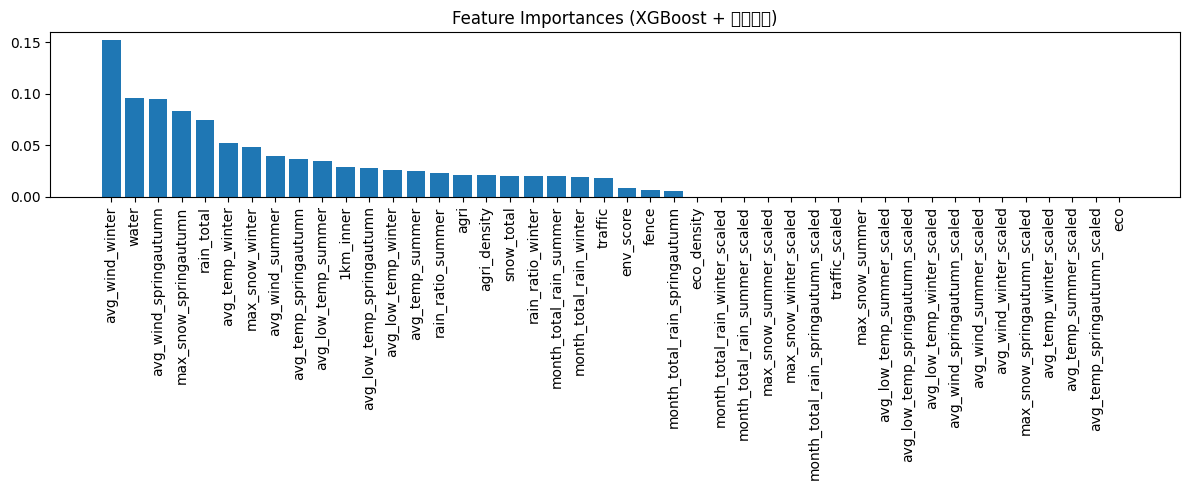

In [5]:
# --------------------------------------------
# 1. 라이브러리 import
# --------------------------------------------
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------
# 2. 데이터 불러오기
# --------------------------------------------
df = pd.read_csv("data/post_1km_robust scaling_0714.csv")

# --------------------------------------------
# 3. 파생변수 생성
# --------------------------------------------
df["rain_ratio_summer"] = df["month_total_rain_summer"] / (
    df["month_total_rain_springautumn"] + 1e-5
)
df["rain_ratio_winter"] = df["month_total_rain_winter"] / (
    df["month_total_rain_springautumn"] + 1e-5
)
df["env_score"] = df["eco"] + df["agri"] + df["water"] + df["fence"]
df["snow_total"] = (
    df["max_snow_springautumn"] + df["max_snow_summer"] + df["max_snow_winter"]
)
df["rain_total"] = (
    df["month_total_rain_springautumn"]
    + df["month_total_rain_summer"]
    + df["month_total_rain_winter"]
)
df["eco_density"] = df["eco"] * df["traffic"]
df["agri_density"] = df["agri"] * df["traffic"]

# --------------------------------------------
# 4. target 컬럼 생성
# --------------------------------------------
df["target"] = (df["count"] > 0).astype(int)

# --------------------------------------------
# 5. Feature / Target 분리
# --------------------------------------------
cols_to_drop = ["count", "post_group", "year", "count_scaled", "target"]
cols_to_drop = [col for col in cols_to_drop if col in df.columns]

X = df.drop(columns=cols_to_drop)
y = df["target"]

print("✅ Feature shape:", X.shape)

# --------------------------------------------
# 6. Train-test split
# --------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --------------------------------------------
# 7. SMOTE 오버샘플링
# --------------------------------------------
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

print("✅ SMOTE 후 분포:\n", y_res.value_counts())

# --------------------------------------------
# 8. XGBoost 학습
# --------------------------------------------
model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    scale_pos_weight=1,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss",
)

model.fit(X_res, y_res)

# --------------------------------------------
# 9. 예측 및 평가
# --------------------------------------------
y_pred = model.predict(X_test)

print("\n✅ Classification Report\n")
print(classification_report(y_test, y_pred))

print("\n✅ Confusion Matrix\n")
print(confusion_matrix(y_test, y_pred))

# --------------------------------------------
# 10. Feature Importance
# --------------------------------------------
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 5))
plt.title("Feature Importances (XGBoost + 파생변수)")
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), [X.columns[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

# ✅ 1. 파일 불러오기
df = pd.read_csv("data/post_1km_robust scaling_0714.csv")

# ✅ 2. 파생변수 생성 (이전 코드 그대로!) + 파생변수 만든거 씀
df["rain_ratio_summer"] = df["month_total_rain_summer"] / (
    df["month_total_rain_springautumn"] + 1e-5
)
df["rain_ratio_winter"] = df["month_total_rain_winter"] / (
    df["month_total_rain_springautumn"] + 1e-5
)
df["env_score"] = df["eco"] + df["agri"] + df["water"] + df["fence"]
df["snow_total"] = (
    df["max_snow_springautumn"] + df["max_snow_summer"] + df["max_snow_winter"]
)
df["rain_total"] = (
    df["month_total_rain_springautumn"]
    + df["month_total_rain_summer"]
    + df["month_total_rain_winter"]
)
df["eco_density"] = df["eco"] * df["traffic"]
df["agri_density"] = df["agri"] * df["traffic"]

# ✅ 3. risk_index 계산
df["risk_index"] = (
    0.4 * df["traffic"]
    + 0.2 * df["env_score"]
    + 0.2 * df["rain_ratio_winter"]
    + 0.1 * df["rain_total"]
    + 0.1 * df["eco_density"]
)

# ✅ 4. risk_index 기준 Top10 추출
top10 = df.sort_values("risk_index", ascending=False).head(10)

# ✅ 5. 필요한 컬럼만 출력
print(top10[["post_group", "year", "risk_index"]])

# ✅ 6. CSV로 저장 (선택)
top10.to_csv("Top10_risk_index.csv", index=False, encoding="utf-8-sig")

      post_group  year  risk_index
1767        2940  2022   650.45333
1761        2930  2022   650.45333
1797        2990  2022   650.25333
1827        3040  2022   650.25333
1791        2980  2022   650.25333
1803        3000  2022   650.25333
1785        2970  2022   650.25333
1779        2960  2022   650.25333
1839        3060  2022   650.25333
1749        2910  2022   650.25333


In [8]:
import shap

# 모델 학습 후
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# 한 개 샘플 설명
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0])

ModuleNotFoundError: No module named 'shap'

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

X = df_balanced.drop(columns=['risk_index', 'risk_level', 'count'])
y = df_balanced['risk_level']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

model = RandomForestClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        high       0.99      0.91      0.95       119
         low       0.98      0.96      0.97       113
         mid       0.96      0.99      0.98       404

    accuracy                           0.97       636
   macro avg       0.98      0.95      0.96       636
weighted avg       0.97      0.97      0.97       636



MSE: 0.0000
RMSE: 0.0060
R² Score: 0.9966


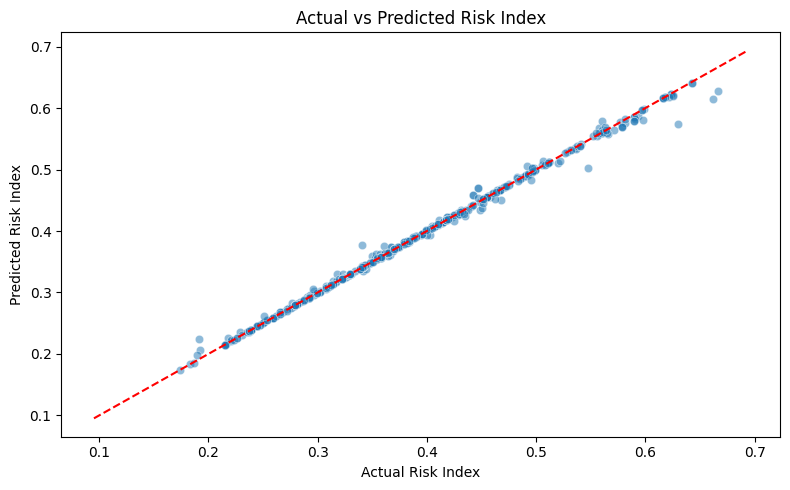

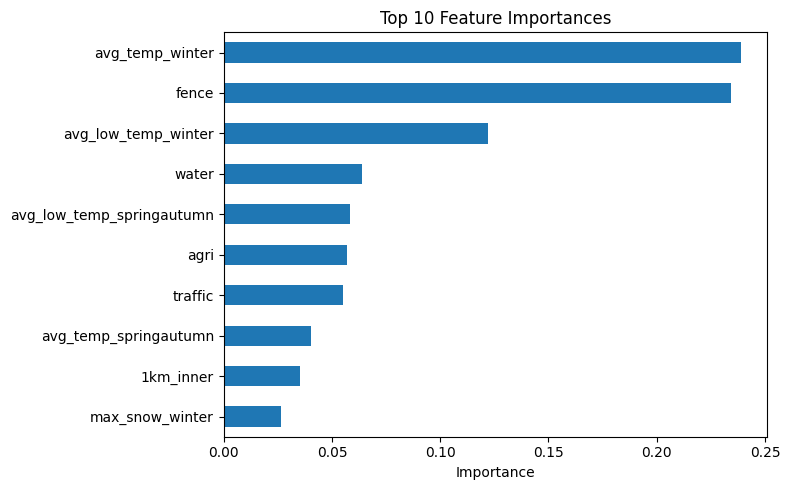

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 준비 (이미 전처리한 df_balanced 사용)
X = df_balanced.drop(columns=['risk_index', 'risk_level', 'count'])
y = df_balanced['risk_index']

# 학습/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# RandomForestRegressor 모델 생성 및 학습
regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(X_train, y_train)

# 예측 수행
y_pred = regressor.predict(X_test)

# 성능 평가
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# 실제값과 예측값 비교 시각화
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.xlabel("Actual Risk Index")
plt.ylabel("Predicted Risk Index")
plt.title("Actual vs Predicted Risk Index")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # y=x 직선
plt.tight_layout()
plt.show()

# 변수 중요도 시각화
importances = pd.Series(regressor.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).head(10).plot(kind='barh', figsize=(8,5))
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
